# Notebook 1: FMRI Data and First-Level Analysis

In this notebook, you'll be introduced to fMRI analysis in Python and we will perform a first-level analysis. As with most statistical fields, there are many ways to analyze data in fMRI. Here, once we have covered some basics, we will introduce you to one of the most commonplace approaches; the mass-univariate linear model and use it to run a first-level analysis. 

### Table of Contents

 - [Notebook 0: Introduction](./nb_00_introduction.ipynb)
 - [**Notebook 1: FMRI Data and First-Level Analysis**](./nb_01_fmri_data_and_first_level_analysis.ipynb)
   - [Getting Started](#Getting-Started)
     - [Loading the Data](#Loading-the-Data)
     - [The NIfTI and img file formats](#The-NIfTI-and-img-file-formats)
     - [Preprocessing](#Preprocessing)
     - [The Linear Model for Imaging Data](#The-Linear-Model-for-Imaging-Data)
     - [First-Level vs Second-Level Analysis](#First-Level-vs-Second-Level-Analysis)
   - [First-level Analysis: An example](#First-level-Analysis:-An-example)
     - [Building $X$ and Fitting the Model](#Building-$X$-and-Fitting-the-Model)
     - [Creating a Contrast Vector](#Creating-a-Contrast-Vector)
     - [Computing Effect Sizes](#Computing-Effect-Sizes)
     - [Computing $Z$- and $t$-Statistic Maps](#Computing-$Z$--and-$t$-Statistic-Maps)
     - [Thresholding your Results](#Thresholding-your-Results)
     - [$F$-Tests](#$F$-Tests)
   - [Exercises](#Exercises)
     
     
 - [Notebook 2: Second-Level Analysis](./nb_02_second_level_analysis.ipynb)

## Getting Started

To begin, let's load in the `nibabel` (we shall use this to manipulate `nifti` and `img` files) and `nilearn` packages which we shall use to perform statistical analysis. The `nilearn` package makes heavy use of `matplotlib`, and so we will need to make sure we have matplotlib configured correctly (this is what the `%matplotlib inline` command is doing).

In [2]:
%matplotlib inline
import nibabel as nib
import nilearn
import os

### Loading the Data

To begin with, lets load in some example data! The example we will be running through in this notebook is borrowed from the [single-session, single-subject fMRI example from the nilearn website](https://nilearn.github.io/stable/auto_examples/plot_single_subject_single_run.html) but was originally collected by the [FIL methods group which develops the SPM software](https://www.fil.ion.ucl.ac.uk/spm/data/auditory/). 

Rather handily, the nilearn package includes this data as a freely available example which can be retreived with the `fetch_spm_auditory` function in the `datasets` module.

In [3]:
from nilearn.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()

/apps/eb/software/Python/3.7.2-GCCcore-8.2.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


To create this dataset, 100 scans were acquired from a single subject during a single session using a repetition time (TR) of 7 seconds (we have one scan per 7 seconds). The first four scans have been removed during preprocessing.

The subject underwent alternating periods of stimulation and rest, lasting 42s each (that is, for 6 scans). The stimulation consisted of bi-syllabic words being presented binaurally (through audio, to both ears) at a rate of 60 per minute.  

Let's have a look at what is in the `subject_data` object.

In [4]:
subject_data

{'func': ['/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
  '/home/inf852/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
  '/home/inf852/n

So as can be seen the `subject_data` object is a dict containing $3$ keys; `func`, `anat` and `events`. Let's go through each of these and see what they are;

 - `func`: This is the subject's functional data (i.e. the fMRI images representing [BOLD response](https://en.wikipedia.org/wiki/Blood-oxygen-level-dependent_imaging)). There are 96 of these images.
 - `anat`: This is the subject's anatomical data (i.e. an image of their physical anatomy, taken for reference). There is only one anatomical image.
 - `events`: This file contains information about the experimental design (i.e. details on when the stimulated and rest periods were).

 > **Note:** In general, there is no agreed-upon standard in the imaging literature for naming and storing the results of an imaging session (although there are proposed approaches; c.f. [BIDS and NIDM](https://www.incf.org/blog/bids-and-neuroimaging-data-model-nidm)). However, in most cases you will find that the functional data is named something along the lines of `functional` and the anatomical is named something along the lines of `anatomical` or `structural`.

Let's load in a functional image and the anatomical to have a look!

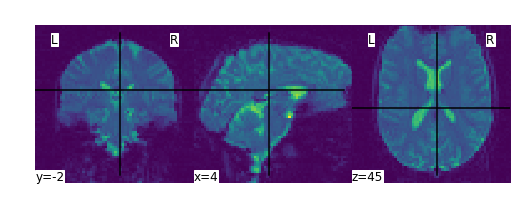

In [5]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

# Plot the 11th (remember zero-indexing!) functional image
plot_img(subject_data.func[10])

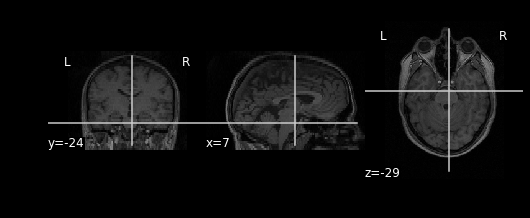

In [6]:
# Plot the subjects anatomical data
plot_anat(subject_data.anat)

Investigate the `plot_img` [documentation](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_img.html#nilearn.plotting.plot_img) to see if you can get the above images to line up!

Now, let's have a brief look at the event's file:

In [7]:
import pandas as pd
events = pd.read_csv(subject_data['events'],sep='\t')
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


As we can see, it tells us the `onset` of each "block" in the design (e.g. the time the block began), the `duration` of the block, and the `trial_type` of the block (i.e. what was happening during the block? Was the subject active or at rest?).

### The NIfTI and img file formats

Before we move on to some statistics analysis, it's worth just providing a little bit of background on the `img` file format and what is stored inside it. Let's try loading an `img` file in. 

We can do this using the nibabel `load` function!

In [8]:
img = nib.load(os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223','fM00223_099.img'))

print(img)

<class 'nibabel.nifti1.Nifti1Pair'>
data shape (64, 64, 64)
affine: 
[[ -3.   0.   0.  93.]
 [  0.   3.   0. -93.]
 [  0.   0.   3. -66.]
 [  0.   0.   0.   1.]]
metadata:
<class 'nibabel.nifti1.Nifti1PairHeader'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 64 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b  

When we print this `img` object we get a load of metadata! Let's highlight a few notable things here;

 - We have the shape of the data; `(64,64,64)`. 
 
   This means that in each image we have $64\times 64\times 64=262144$ voxels (3D pixels). Typically, the brain takes up approximately a third of the image so this means we probably have about $262144/3\approx 87381$ datapoints *per image!* (and these are small images!).
   
   
 - We have the `affine` of the data. This tells us the position of the image array data in a reference space. In other words, during data collection and preprocessing, this data may have undergone a number of transformations to make all of the images "look nice" and "line up" with one another. This `affine` tells us how we can transform our version of the image back to the original frame of reference.
 
 
 - We have the `nibabel.nifti1.Nifti1PairHeader` object. This `header` object stores all sorts of useful information about the data. We won't go into too much detail on the header here but there's a very good blog post [here](https://brainder.org/2012/09/23/the-nifti-file-format/) if you wanted to read a bit more.
 
You might be wondering at this point "where's the image data?". Well, `img` is an `nibabel.nifti1` object and `nibabel` allows us to access information inside `nibabel.nifti1` objects using the `dataobj` property like so;

In [9]:
# Read the data
img_data = img.dataobj

# Print the data shape
print(img_data.shape)

# Try accessing some elements of the data
print(img_data[10:12,50:54,30:35])

# Print the type of the data 
print(type(img_data))

(64, 64, 64)
[[[ 349.  414.  230.  150.  248.]
  [ 382.  508.  359.  248.  226.]
  [ 211.  392.  470.  374.  253.]
  [ 312.  360.  493.  455.  326.]]

 [[ 537.  301.  388.  989. 1198.]
  [ 466.  206.  556.  618.  758.]
  [ 414.  374.  229.  459.  279.]
  [ 394.  406.  471.  508.  264.]]]
<class 'nibabel.arrayproxy.ArrayProxy'>


We can manipulate and use the `img_data` object much like we would a numpy array! In fact, you may be thinking "why don't we just use a numpy array instead of whatever a `nibabel.arrayproxy.ArrayProxy` is?".

The short answer to this question is; memory. Neuroimaging data is large. Very large. If you were to try and load all the data in this example in as numpy arrays you would likely run into a memory error and crash the notebook. And this example is small.

Nibabel is a very powerful tool as it handles a lot of these memory issues for you behind the scenes. Instead of creating a numpy array, nibabel has created something called a `memmap` here, which basically only loads in data when you ask for it! For instance, in the above example the elements `[10:12,50:54,30:35]` weren't read into working memory until we explicitly asked for them.

 > **Tip:** If you're working with neuroimaging data and everything is running slowly, check if you have your data saved as a `memmap` or as a `np.array`. It could save you years of your life!

There's one final piece of data storage related information worth noting. If we look inside the `nilearn_data` folder, we can see that every `img` file has a corresponding `hdr` file.

In [10]:
print(os.listdir(os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223')))

['fM00223_042.img', 'fM00223_034.hdr', 'fM00223_009.hdr', 'fM00223_020.img', 'fM00223_021.img', 'fM00223_031.hdr', 'fM00223_062.hdr', 'fM00223_065.img', 'fM00223_015.hdr', 'fM00223_057.hdr', 'fM00223_044.hdr', 'fM00223_096.hdr', 'fM00223_091.hdr', 'fM00223_083.hdr', 'fM00223_087.img', 'fM00223_035.img', 'fM00223_024.hdr', 'fM00223_048.img', 'fM00223_027.hdr', 'fM00223_057.img', 'fM00223_028.img', 'fM00223_091.img', 'fM00223_047.hdr', 'fM00223_029.img', 'fM00223_095.img', 'fM00223_042.hdr', 'fM00223_085.img', 'fM00223_038.hdr', 'fM00223_050.img', 'fM00223_053.img', 'fM00223_030.img', 'fM00223_036.hdr', 'fM00223_028.hdr', 'fM00223_095.hdr', 'fM00223_089.hdr', 'fM00223_031.img', 'fM00223_070.img', 'fM00223_087.hdr', 'fM00223_069.img', 'fM00223_063.hdr', 'fM00223_012.hdr', 'fM00223_074.img', 'fM00223_014.img', 'fM00223_088.hdr', 'fM00223_023.hdr', 'fM00223_097.img', 'fM00223_086.hdr', 'fM00223_049.img', 'fM00223_078.img', 'fM00223_081.hdr', 'fM00223_079.img', 'fM00223_051.hdr', 'fM00223_01

If we move the `hdr` file, weirdly we can't use the `img` file anymore.

In [11]:
# Get the filename of a hdr file and make a temporary filename 
hdr_file = os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223','fM00223_099.hdr')
tmp_file = os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223','tmp.hdr')

# Move the hdr file
os.rename(hdr_file, tmp_file)

# Try to load in the img file now
img = nib.load(os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223','fM00223_099.img'))

ImageFileError: Cannot work out file type of "../nilearn_data/spm_auditory/sub001/fM00223/fM00223_099.img"

However, if we move the `hdr` file back in place, we can load in the `img` file.

In [12]:
os.rename(tmp_file, hdr_file)
img3 = nib.load(os.path.join('..','nilearn_data','spm_auditory','sub001','fM00223','fM00223_099.img'))

This is a bit annoying... this is happening because `img` and `hdr` files come in pairs. The `img` file contains the data and the `hdr` file contains the header meta-data we were looking at earlier.

Because this is a bit of a pain, people often use a "Neuroimaging Informatics Technology Initiative" (NIfTI) file format instead. Simply put, a NIfTI file is just combination of the information inside the `img` and `hdr` files, saved under a `.nii` extension.

`NIfTI` files are popular and often the default file extension used in neuroimaging, so you may find that as you work through this tutorial a lot of the results we are saving are saved as `.nii` rather than `.img`. Just remember that the `.nii` file is basically just the same thing as "`.img`+`.hdr`". Here's a quick example;

In [13]:
from nilearn.image import mean_img

# Lets make a mean image of the subjects functional data
mean_img = mean_img(subject_data.func)

# Lets save the result 
nib.save(mean_img, os.path.join('..','nilearn_data','spm_auditory','sub001','mean_image'))

# Let's see what it saved it as:
print(os.listdir(os.path.join('..','nilearn_data','spm_auditory','sub001')))

['README.txt', 'README_analysis.txt', 'sM00223', 'fM00223', 'mean_image.nii']


We now have a `mean_image.nii` file. It is worth stressing that all of the tools we use in this notebook will work for both `.img` and `.nii` files.

### Preprocessing

If you've never worked with imaging data before you might at this point be thinking something along the lines of "hey, don't people move in the scanner though?" or "surely, we're going to have to do something else to make these images line up?". Normally, you would address such questions when you preprocess your data. But for our purposes today, this has already been done for you. 

That said, preprocessing is an important part of any imaging study and it is important to know what has happened to the data before analysis, so that you can understand what the analysis is taking care of. Here we'll just briefly list a few common preprocessing steps which may have been applied to the data before analysis:

- **Distortion Correction:** Functional MRI images are generated using a magnetic field induced by a superconducting coil. In theory, the magnetic field should be perfectly homogeneous and uniform across space. However, in practice, inhomogeneities in the magnetic field are common, often caused by differences in the magnetic susceptibility properties of the tissue types being scanned. Fortunately, magnetic field inhomogeneties behave in a predictable manner and are often fixed in a preprocessing stage by "warping" an image.
    
    
- **Motion Correction:** Image acquisition can be a lengthy process and it is difficult for participants to remain completely still for such prolonged periods of time. As a result, it is inevitable that there will be some movement of the head during any image acquisition. In this stage of the pre-processing pipeline, images are transformed to line up with one another (often the middle image of the time series is used as a reference).


- **Co-registration:** In order to compare them to something meaningful, we usually want our images to "line-up" or be "aligned" to the subject's anatomy. For this reason, the images are often "co-registered" to the subject's anatomical image (e.g. `sM00223_002.img`) during pre-processing. This means that all of the images have now been transformed to have the same shape and size as the subject's anatomical image.


- **Registration:** Often, we are also interested in comparing the results of analysis "between-subjects". For this reason, images are often aligned to some "standard template" to allow between subject comparison. We will revisit this idea in the next notebook.


- **Brain Extraction:** Non-brain structure, such as the skull and surrounding tissues, are typically removed from all of the images before analysis. This process is performed using the anatomical image as a reference and is also sometimes known as skull-stripping.


- **Spatial Smoothing:** Spatial data is noisy. One thing we can do to combat this is convolve the data with a Gaussian kernel along each of the three dimensions (i.e. make it *smoother*). This is often done during pre-processing but it is also common to perform smoothing during the first-level analysis. We will investigate this further in the first-level example in this notebook.

The above list is non-exhaustive but it does highlight something important about fMRI analysis. Before beginning, statistical analysis, you must always **LOOK AT YOUR DATA!**

Any one of these preprocessing steps could go wrong, and, more often than not, they do!

In the box below have a look through the functional images in `subject_data` using the `plot_img` function. 

In [14]:
# Write your code here...

Think about what it might look like if each of the above preprocessing steps had failed. When you are happy you have looked carefully at the images, move on to the next section.

### The Linear Model for Imaging Data

Okay, we're almost ready to start running code! We will just quickly go over a few statistical concepts and then we will move onto running an analysis! One of the most common approaches employed for analyzing fMRI data is to use the Linear Model (LM). Below, we'll give a brief recap of what the LM looks like;

In the traditional (univariate) settings you are likely familiar with, a LM containing $n$ observations typically takes the following form:

$$Y=X\beta + \epsilon$$ 

where $\epsilon \sim N(0,\Sigma)$. In this model;

 - $Y$ is an $(n \times 1)$-shaped response vector; i.e. some variable which we have several measurements for and are interested in modelling.
 - $X$ is an $(n \times p)$-shaped design matrix. $X$ typically contains information about the study you have run (e.g. variables describing the experiment setup, the participants involved,... etc).
 - $\beta$ is a $(p \times 1)$-shaped parameter vector. The parameter vector tells us how the columns of $X$ (known as the regressors or independent variables) interact with the response vector $Y$.
 - $\epsilon$ is an $(n \times 1)$-shaped error term representing noise.
 - $\Sigma$ is the $(n \times n)$ covariance matrix of $\epsilon$. Often, we assume that $\Sigma$ takes some special form to save us from having to deal with $n^2$ covariance terms. For example, in the analysis we will run shortly, we take $\Sigma$ to have an AR(1) structure.

IMAGE

Moving to imaging, it can become a bit confusing what exactly $X$ and $Y$ are. In imaging, we do not have a single response vector $Y$, but rather we have a response vector for *each voxel* (i.e. each location in the brain). This means that, essentially, we don't just have one model, but rather thousands of models, each one corresponding to a different location in the brain.

For the $v^{th}$ voxel in the image, we have a model that looks something like this;

$$Y_v = X \beta_v + \epsilon_v$$
where $\epsilon_v \sim N(0,\Sigma_v)$.  In this model;

 - $Y_v$ is an $(n \times 1)$-shaped response vector representing the response *at voxel $v$*.
 - $X$ still the $(n \times p)$-shaped design matrix.
 - $\beta_v$ is a $(p \times 1)$-shaped parameter vector modelling the parameters *for voxel $v$*.
 - $\epsilon_v$ is an $(n \times 1)$-shaped error term representing noise *at voxel $v$*.
 - $\Sigma_v$ is the $(n \times n)$ covariance matrix of $\epsilon_v$.


The above model is often referred to as a *mass-univariate* Linear Model, as each voxel has it's own seperate univariate model (and there are a lot of voxels!)!


> **Note:** You may be wondering why we have so many univariate models, instead of just combining everything together into a single multivariate model. Simply put, a multivariate model would be massively overparameterized. In this example, we have $n=96$ observations. If we tried to model this using a multivariate model we would have $pv$ parameters to estimate, where $p$ is the number of columns of $X$ (which is $16$ in the following example) and $v$ is the number of voxels in the brain (which we saw earlier was approximately $87381$). 
>
> You could certainly try using your favourite approach to estimating overparameterized models to try to get something meaningful but given how small $n$ ($=96$) is in comparison to $pv$ ($=1398096$), it certainly isn't looking likely you will get anything of use.

It's worth emphasizing that $X$ does not have a subscript $v$. This is because $X$ contains information about the experimental design (e.g. from the `events.tsv` file) and this information does not depend on which voxel we are looking at!

> **Note:** Some analyses may include voxel-specific information in $X$, but we won't get into that here!

In a mass-univariate analysis, we are running a lot of statistical tests (one for each voxel in the brain), and therefore a multiple comparisons correction must be employed once we have run our analysis. We'll talk about this a little bit more after we have generated some statistics.

### First-Level vs Second-Level Analysis

The last thing we need to explain before moving onto running the example is the difference between a "first" and "second" level analysis. 

#### First-Level Analysis

In fMRI, a first-level analysis, also known as a "subject-level" analysis, usually involves combining data drawn from a single subject. The subject has typically performed some task, and we have one scan per timepoint during the task.

The aim of a first-level analysis is to combine several scans taken from the same subject, each of which corresponds to a timepoint, to perform some inference which assess *that subjects* response to the stimuli. 

#### Second-Level Analysis

A second-level analysis, also known as a "group-level" analysis, usually involves combining results from several first-level analyses. All subjects have performed the same task, the same first-level analysis has been run for each subject, and, from this, we now have one scan per subject.

The aim of a second-level analysis is to combine the results of several first-level analyses, each of which corresponds to a subject, to perform some inference which assess *the groups* response to the stimuli. 

In short, a first-level analysis combines *timepoints for a subject* and a second-level analysis combines *subjects in a group*.

> **Note:** Again, if you are statistically minded you might be thinking, "why are these models run seperately? Couldn't they be combined into some sort of mixed model or something?". The answer here is; yes, often this is done. 
> 
> However, equally often there simply isn't enough data to accurately model all of the covariance terms such a model would require (remember we only have $n=96$!). There has been a whole literature arguing for and against the "two-stage" approach described above (c.f. [Friston, et al. (2005)](https://pubmed.ncbi.nlm.nih.gov/15588616/), [Worsley, et al. (2002)](https://pubmed.ncbi.nlm.nih.gov/11771969/)). Regardless, it is still one of the most popular approaches employed today. 
> 
> Another important factor is computation time, but that's a whole other discussion!

## First-level Analysis: An example

Alright, finally! Let's get onto running a first-level analysis. To begin with let's build the design matrix, $X$.

### Building $X$ and Fitting the Model

`nilearn` contains a `first-level` module for running the linear model on subject-level data. To use it the first thing we have to do is initialize a new `FirstLevelModel` object.

In [15]:
from nilearn.glm.first_level import FirstLevelModel

# Initialize the first level model
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

print(fmri_glm)

FirstLevelModel(hrf_model='spm', signal_scaling=True, t_r=7)


In the above code we have initialised a new `FirstLevelModel` object called `fmri_glm`. At the moment `fmri_glm` only contains some very basic information about the analysis we wish to run. In the above code, we have told the `fmri_glm` the following information;

 - `t_r`: The time of repetition (between scans) in seconds.
 
 
 - `noise_model`: The model we are assuming for the noise. In this case, we have selected an [AR($1$) model](https://en.wikipedia.org/wiki/Autoregressive_model) for $\Sigma_v$.
 
 
 - `standardize`: This setting controls whether the time series are centered and normalized. As we have included an intercept in the design matrix (the last column of $X$) we do not need centering. As normalizing is also not necessary here we have set this to `False`.
 
 
 - `hrf_model`: In reality, we don't expect the brain to just turn "on" and "off" like a switch when neuronal activity occurs. The biology of neuronal activity is complex and must be modelled using the [Heamodynamic Response Function](https://en.wikipedia.org/wiki/Haemodynamic_response#:~:text=Haemodynamic%20response%20(HR)%20allows%20the,blood%20to%20active%20neuronal%20tissues.&text=Since%20higher%20processes%20in%20the,other%20cells%20of%20the%20brain.). In a very loose sense you can think of the Heamodynamic Response Function as a model of how a part of the brain "warms up" and "starts working" when need to start using it. There are several versions of the HRF model we could use during analysis but in general the `spm` one is fairly standard.
 
 
 - `drift_model`: This parameter tells us how we want to model drift in our timeseries data. The drift model is a set of slow oscillating functions (in our case Discrete Cosine transform) with a cut-off frequency. We use this model to represent and remove spurious low-frequency effects related to heart rate, breathing and slow drifts in the scanner signal, which we could do by setting the cutoff frequency to 1/128 Hz ~ 0.01Hz. Often we set a cutoff period as the longest period between two trials of the same condition multiplied by 2. For instance, in our case the longest period is 42s, so the `high_pass` frequency shall be 1/84 Hz ~ 0.012 Hz. This has the effect of removing periodic behaviour which is too long to be caused by our experiment. [Here](https://www.brainvoyager.com/bvqx/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html) is a good article if you wanted to read more about this.
 
 
 
 - `high_pass`: This is the cutoff period mentioned above. In this case we have gone for 0.01Hz. 

Okay, now we have set up a `FirstLevelModel` object, we have to pass it some data. To do this we must concatenate all of the functional data into one 4D volume and pass it to the `fmri_glm.fit` method, alongside the `events.tsv`. 

In [16]:
from nilearn.image import concat_imgs

# Join all the 3d functions images together into one 4d volume
fmri_img = concat_imgs(subject_data.func)

# Fit the linear model by passing the images and experimental design information to nilearn.
fmri_glm = fmri_glm.fit(fmri_img, events)

Behind the scenes, here we are essentially giving `nilearn` the information it needs to construct $Y_v$ for every voxel $v$ and to construct $X$. `nilearn` is then using this information to construct the linear model and perform parameter estimation for each voxel in the brain (i.e. `nilearn` is estimating $\beta_v$ and $\Sigma_v$ for every voxel $v$).

Before we start looking at the model fit and results, let's first look at the design matrix $X$, which nilearn has constructed. We can get this using the `design_matrices_` property of `fmri_glm`.

In [17]:
design_matrix = fmri_glm.design_matrices_[0]

We can make an image representing the design matrix in nilearn by using the `plot_design_matrix` function from `nilearn.plotting`.

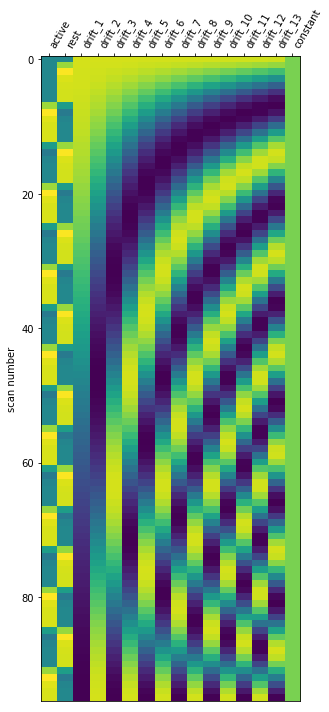

In [18]:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Create design matrix plot
plot_design_matrix(design_matrix)

# Show the plot
plt.show()

In the above image the colors correspond to the numerical values in the design matrix. If your unsure what the above image means, try comparing it to the design in numerical form given below.

In [19]:
design_matrix

,active,rest,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,drift_12,drift_13,constant
0.0,0.000000,0.000000,0.144318,0.144260,0.144164,0.144029,0.143855,0.143643,0.143392,0.143103,0.142775,0.142410,0.142006,0.141564,0.141084,1.0
7.0,0.000000,0.817784,0.144164,0.143643,0.142775,0.141564,0.140012,0.138122,0.135900,0.133351,0.130480,0.127294,0.123802,0.120012,0.115933,1.0
14.0,0.000000,1.129175,0.143855,0.142410,0.140012,0.136678,0.132429,0.127294,0.121308,0.114511,0.106947,0.098668,0.089729,0.080190,0.070114,1.0
21.0,0.000000,1.022902,0.143392,0.140567,0.135900,0.129452,0.121308,0.111574,0.100378,0.087867,0.074204,0.059569,0.044153,0.028159,0.011795,1.0
28.0,0.000000,1.000997,0.142775,0.138122,0.130480,0.120012,0.106947,0.091567,0.074204,0.055236,0.035071,0.014148,-0.007082,-0.028159,-0.048626,1.0
35.0,0.000000,1.000000,0.142006,0.135086,0.123802,0.108519,0.089729,0.068040,0.044153,0.018840,-0.007082,-0.032776,-0.057410,-0.080190,-0.100378,1.0
42.0,0.000000,1.000000,0.141084,0.131472,0.115933,0.095168,0.070114,0.041899,0.011795,-0.018840,-0.048626,-0.076220,-0.100378,-0.120012,-0.134236,1.0
49.0,0.817210,0.182790,0.140012,0.127294,0.106947,0.080190,0.048626,0.014148,-0.021179,-0.055236,-0.085982,-0.111574,-0.130480,-0.141564,-0.144164,1.0
56.0,1.129229,-0.129229,0.138789,0.122572,0.096931,0.063839,0.025839,-0.014148,-0.053046,-0.087867,-0.115933,-0.135086,-0.143855,-0.141564,-0.128391,1.0
63.0,1.022931,-0.022931,0.137418,0.117324,0.085982,0.046396,0.002362,-0.041899,-0.082143,-0.114511,-0.135900,-0.144260,-0.138789,-0.120012,-0.089729,1.0


Before we go any further, let's quickly save the design matrix!

In [20]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(
    design_matrix, output_file=join(outdir, 'design_matrix.png'))

Now, in this design, we had regular periods of activity and rest which were alternated in intervals of $42$ seconds. If we let `1` represent activity and `0` represent rest we might expect that this has been coded into our linear model as something like this.

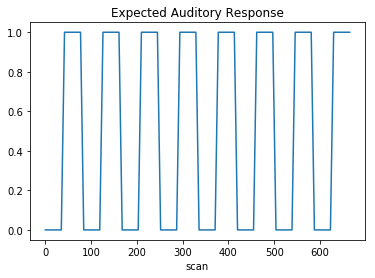

In [21]:
# Read in example file
boxcar = pd.read_csv(os.path.join('boxcar.csv'),index_col=0)

plt.plot(boxcar)
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

However, if we look at our design matrix, the first column corresponds to the `active` periods but it looks like this:

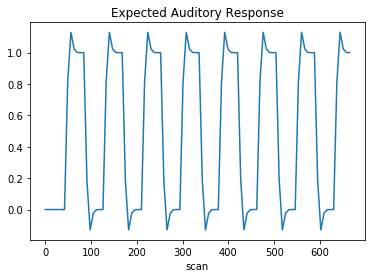

In [22]:
import matplotlib.pyplot as plt
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

What is happening here? Well, as we mentioned before the brain doesn't just switch "on" and "off" in a binary fashion. 

When you engage some part of the brain in cognitive function, it requires oxygen and glucose, which are transported in the blood. Your arteries are able to transport this oxygen and glucose to the required brain area very quickly but they do it in an inefficient way. At first, they overshoot a little and send a bit too much (hence the peaks in the above image). After this, the process levels out and the arteries provide the required amount of oxygen and glucose (hence the flat regions after each peak). Finally, when they are no longer required to do so they stop sending blood and glucose, but again they do this in a slightly inefficient manner and undershoot (hence the dips below after each period of activity). What we are describing here is the Heamodynamic Response Function (HRF) which we mentioned earlier when we set up the `FirstLevelModel` object.

In other words, the above graph isn't just a model of our experimental design, it is a model of how we expect the brain to be reacting to the experimental design. 

You can see the same behaviour in the second column of our design matrix $X$, which describes what we might expect brain regions to be doing if they were responding to the `rest` periods.

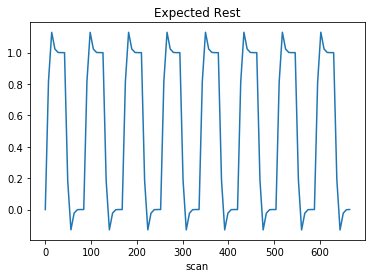

In [23]:
plt.plot(design_matrix['rest'])
plt.xlabel('scan')
plt.title('Expected Rest')
plt.show()

> Mathematicaally speaking, the above images are creating by [convolving](https://en.wikipedia.org/wiki/Convolution) the binary graph two boxes above with a predefined form of the HRF which looks something like [this](https://www.researchgate.net/profile/Antti-Korvenoja/publication/47934203/figure/fig5/AS:667768873570322@1536219914860/The-canonical-hemodynamic-response-function-as-in-SPM99-software.png).

After the first two columns we have our cosine bases, which handle [drift](https://www.brainvoyager.com/bvqx/doc/UsersGuide/Preprocessing/TemporalHighPassFiltering.html) in the data. Here's an example of two of these functions.

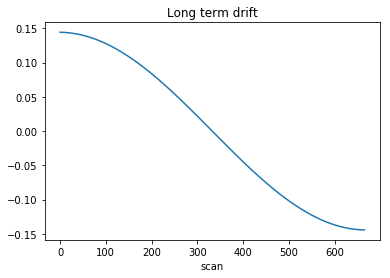

In [24]:
plt.xlabel('scan')
plt.title('Long term drift')
plt.plot(design_matrix['drift_1'])
plt.show()

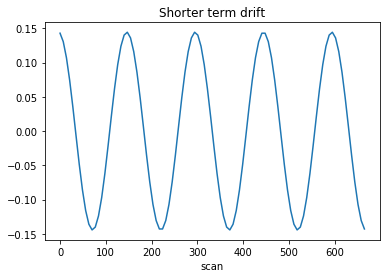

In [25]:
plt.xlabel('scan')
plt.title('Shorter term drift')
plt.plot(design_matrix['drift_9'])
plt.show()

Note how in both of these images the period of oscillation of the `cosine` functions is much larger than in our `active` and `rest` columns. For this reason, if we saw any behaviour like this in the response at a voxel we would expect that such behaviour is nothing to do with our experimental design but is instead related to other physiological factors like heart rate, breathing and slow drifts in the scanner signal.

Including these oscillating functions as columns in $X$ allows us to pick apart which periodic behaviours in our data are due to the experiment and which are due to other factors during analysis.

### Creating a Contrast Vector

So far we have created a `FirstLevelModel` object called `fmri_glm` and told it to fit our model. Now, we shall move onto null-hypothesis testing. 

Often in imaging studies, research questions can be expressed as null hypothesis tests of the below form:

$$H_0: L\beta_v = 0, \quad H_1 : L\beta_v \neq 0$$
    
where $L$ is a fixed and known $(1 \times p)$-sized contrast vector specifying a hypothesis, or prior belief, about linear relationships between the elements of $\beta$, upon which an inference is to be made. Let's look at a few examples for `L`.

In [29]:
import numpy as np

L_A = np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
L_R = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Here, we have two contrast vectors; $L_{A}$ and $L_{R}$. Each contrast vector contains exactly one `1` and `0` everywhere else. 

By basic matrix multiplication, we can see that:

$$L_{A}\beta_v= \begin{bmatrix} 1, & 0, & ..., & 0 \end{bmatrix}\begin{bmatrix}\beta_{1, v}\\ \beta_{2, v}\\ \vdots \\ \beta_{p, v}\end{bmatrix}=\beta_{1,v}$$

where $\beta_{i, v}$ is the $i^{th}$ element of $\beta_{v}$. In other words, if we test the hypothesis that $L_{A}\beta_v$ is equal to zero, we are in fact testing whether the first element of $\beta_v$, $\beta_{1,v}$, is zero.

If we look back at our design matrix $X$, we can see that the first element of $\beta_v$ corresponds to the `Active` column in the design matrix. This means that testing the hypothesis $L_{A}\beta_v=0$ is really equivalent to asking something along the lines of "did the participant being active in the task have a non-zero effect on their brain function (at voxel $v$)?".

Make sure you understand this before moving forward. If you have any questions feel free to ask one of the tutors! Check your understanding by trying to work out which hypothesis $L_R$ represents.

Often we are interested in more complex questions, like "where was there a difference in brain activation between the subject responding to the task and being at rest?". This can be represented using a contrast vector like so;

In [31]:
L_active_minus_rest = L_A - L_R

This is the contrast vector we shall be investigating in the following sections. To visualize the contrast vector `nilearn` has a nice feature called `plot_contrast_matrix`. Try it out below!

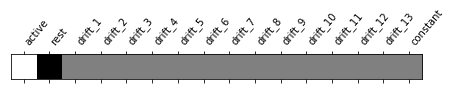

In [32]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(L_active_minus_rest, design_matrix=design_matrix)

### Computing Effect Sizes

We are now ready to move onto creating images of our results!

As we are testing to see whether there is statistical evidence that $L\beta_v$ is non-zero at each voxel, it may of interest to look at an image of the values of $L\hat{\beta}_v$. We can do this using the `compute_contrast` function by setting the `output_type` to `effect_size`.

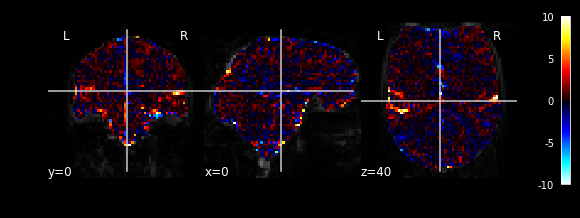

In [33]:
eff_map = fmri_glm.compute_contrast(L_active_minus_rest,
                                    output_type='effect_size')

plot_stat_map(eff_map, bg_img=mean_img, vmax=10, cut_coords=(0,0,40))

 > **Note:** We'll be using the `plot_stat_map` a fair bit in the next sections, if you aren't sure what's happening at any point, check the documentation [here](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_stat_map.html)!

This is nice, we can sort-of see something here! But the above image doesn't really tell us anything rigorous... and it only tells us half the story! How do we know that we are seeing large values of $L\hat{\beta}_v$ by chance? We need to know something about the variance of $L\hat{\beta}_v$ as well! 

Fortunately, nilearn let's us plot a map of $\text{Var}(L\hat{\beta}_v)$ as well by setting `output_type` to `effect_variance`!

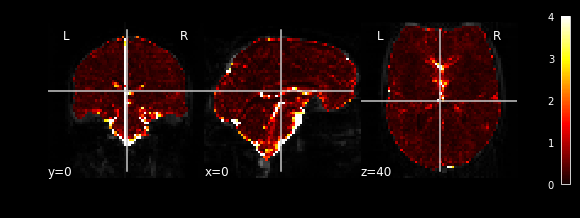

In [34]:
var_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_variance')

plot_stat_map(var_map, bg_img=mean_img,vmax=4, cut_coords=(0,0,40))

This is good, as we can now see there is some pretty strong variance (in white) near the edge of the brain at the bottom of the image, suggesting we might not trust the estimates of $L\beta$ in this region very much!

> **Note:** Mathematically the equation for the variance of $L\hat{\beta}_v$ is given by;
>
> $$\text{Var}(L\hat{\beta}_v)=L(X'\Sigma_v^{-1}X)^{-1}L'$$
>
> However, in practice we don't know the value of $\Sigma_v$ exactly, so this is replaced by $\hat{\Sigma}_v$.

All of this is very well and good but it's a bit handwavy. To really assess these results we need statistical tests...

### Computing $Z$- and $t$-Statistic Maps

$T$-statistics, $Z$-scores, 


$$t_v=\frac{L\hat{\beta}_v}{\sqrt{\text{Var}(L\hat{\beta}_v)}}=\frac{L\hat{\beta}_v}{\sqrt{L(X'\hat{\Sigma}_v^{-1}X)^{-1}L'}}$$

In [ ]:
t_map = fmri_glm.compute_contrast(active_minus_rest,
                                  stat_type='t',
                                  output_type='stat')

plot_stat_map(t_map, bg_img=mean_img,vmax=6, cut_coords=(0,0,40))

$$p_v = 2\times (1-\mathbb{P}[T_{n-p}<t_v|H_0])$$
where $\mathbb{P}[T_{n-p}<t_v|H_0]$ is cdf of student's $t$ distribution with $n-p$ degrees of freedom.

In [ ]:
p_map = fmri_glm.compute_contrast(active_minus_rest,
                                  stat_type='t',
                                  output_type='p_value')

plot_stat_map(p_map, bg_img=mean_img, cut_coords=(0,0,40))

Some people also like to look at maps of $Z$ values...

$$Z_v = \Phi^{-1}\bigg(1-\frac{p_v}{2}\bigg)$$

In [ ]:
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  stat_type='t',
                                  output_type='z_score')

plot_stat_map(z_map, bg_img=mean_img, cut_coords=(0,0,40))

Personally, I find this a little misleading, as you did not originally generate $Z$-scores but to each their own.

All very messy and hard to interpret at the moment so let's look at thresholding...

### Thresholding your Results

Can directly threshold - let's look at where effect size greater than 1. 


In [ ]:
plot_stat_map(eff_map, bg_img=mean_img, threshold=1,
              display_mode='z', cut_coords=3, vmax=10, black_bg=True,
              title='Active minus Rest (LB>1)')
plt.show()

Here, we are just looking at all of the voxels where we had that $L\hat{\beta}_v>1$. This is okay as a quick diagnostic to look at, but it is hardly rigorous and there's not all that much we can realistically read into it.

Uncorrected = BAD

In [ ]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control=None)
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.001)')
plt.show()

False positive rate

In [ ]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.001)')

FPR controls #fps/(#fps + #tns)

$$FPR = \mathbb{E}\bigg[\frac{FP}{FP + TN}\bigg]=\alpha$$
problem... lift from notebook


So FWE

In [ ]:
_, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.05, corrected)')

This conservative; popular alternative = FDR

In [ ]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05)')

Though has been thrown into question a bit lately. 

$$FDR = \mathbb{E}\bigg[\frac{FP}{FP + TP}\bigg]=\alpha$$

Can also do cluster thresholding...

In [ ]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05), clusters > 10 voxels')
plt.show()


Something that used to be popular but not so much now is to get a table of peaks and clusters

In [ ]:
from nilearn.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
table

### $F$-Tests

$$F_v=\frac{\hat{\beta}'_vL'[L(X'\hat{\Sigma}^{-1}_vX)^{-1}L']^{-1}L\hat{\beta}_v}{rank(L)}$$

In [ ]:
import numpy as np
effects_of_interest = np.vstack((conditions['active'], conditions['rest']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')

# Exercises

**Question 1:** Return to where you first fit the model, with `FirstLevelModel` and add a smoothing option, e.g. `smoothing_fwhm=6`, to add a 6 mm FWHM smoothing kernel. Try a range of values for this and compare the images you get as a result. What effect does increasing the smoothing have on your results? Why do you think this is?


**Question 2:** investigate some other threshold options; play around - whats giving you best results and why? Be very careful with your answer. Explain why in practice you wouldn't repeatedly threshold in this way.


**Question 3:** In the next notebook we will be looking at group.. conceptually this means... before moving on.. try and think a little about what might be different in a group vs subject analysis and why#

**Extra:** https://nilearn.github.io/auto_examples/04_glm_first_level/plot_first_level_details.html
https://nilearn.github.io/glm/first_level_model.html https://nilearn.github.io/glm/glm_intro.html